# 算法原理

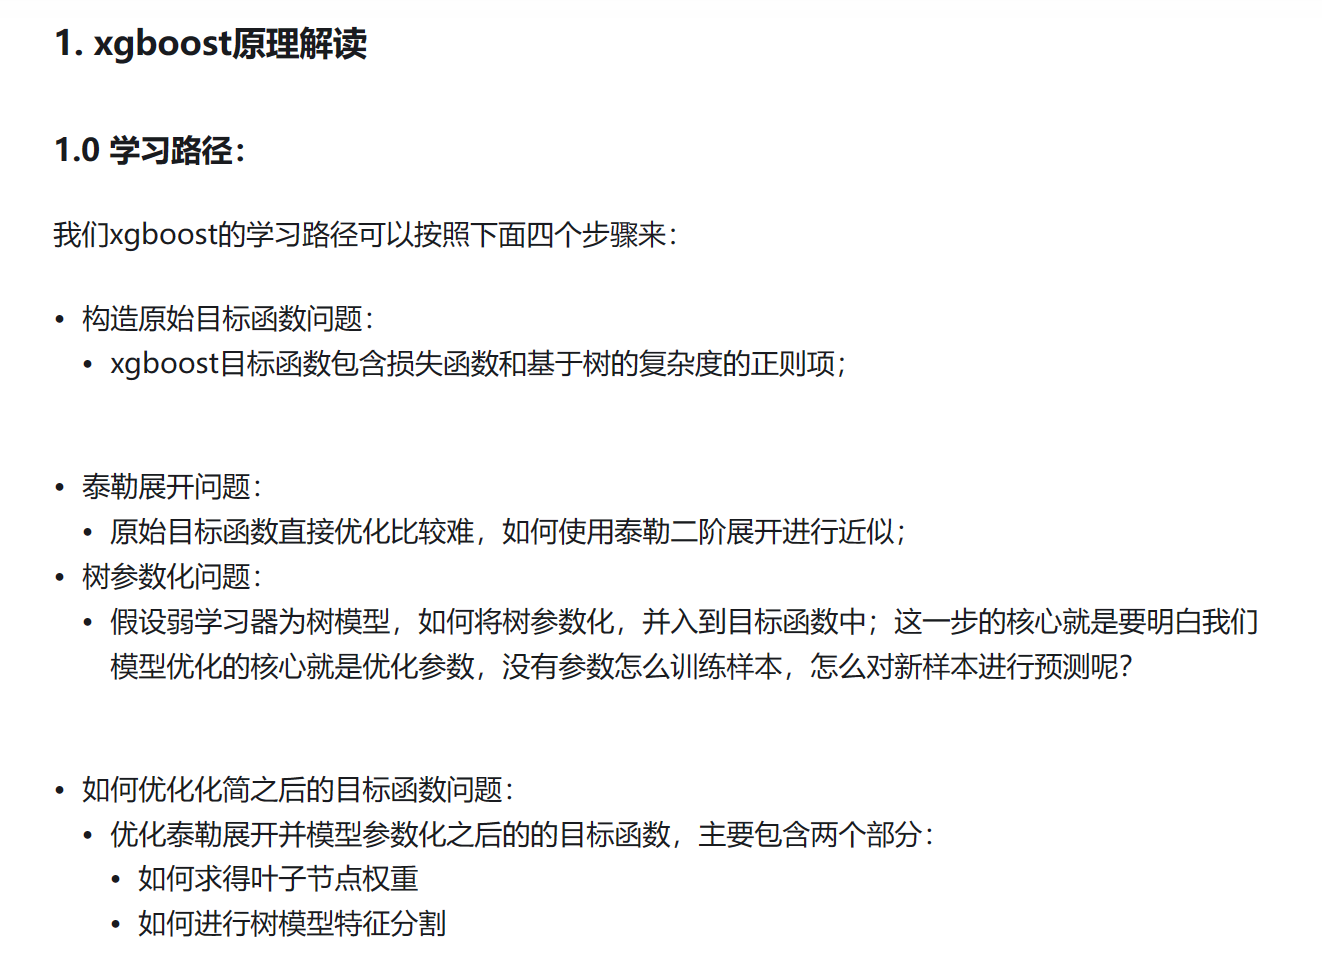
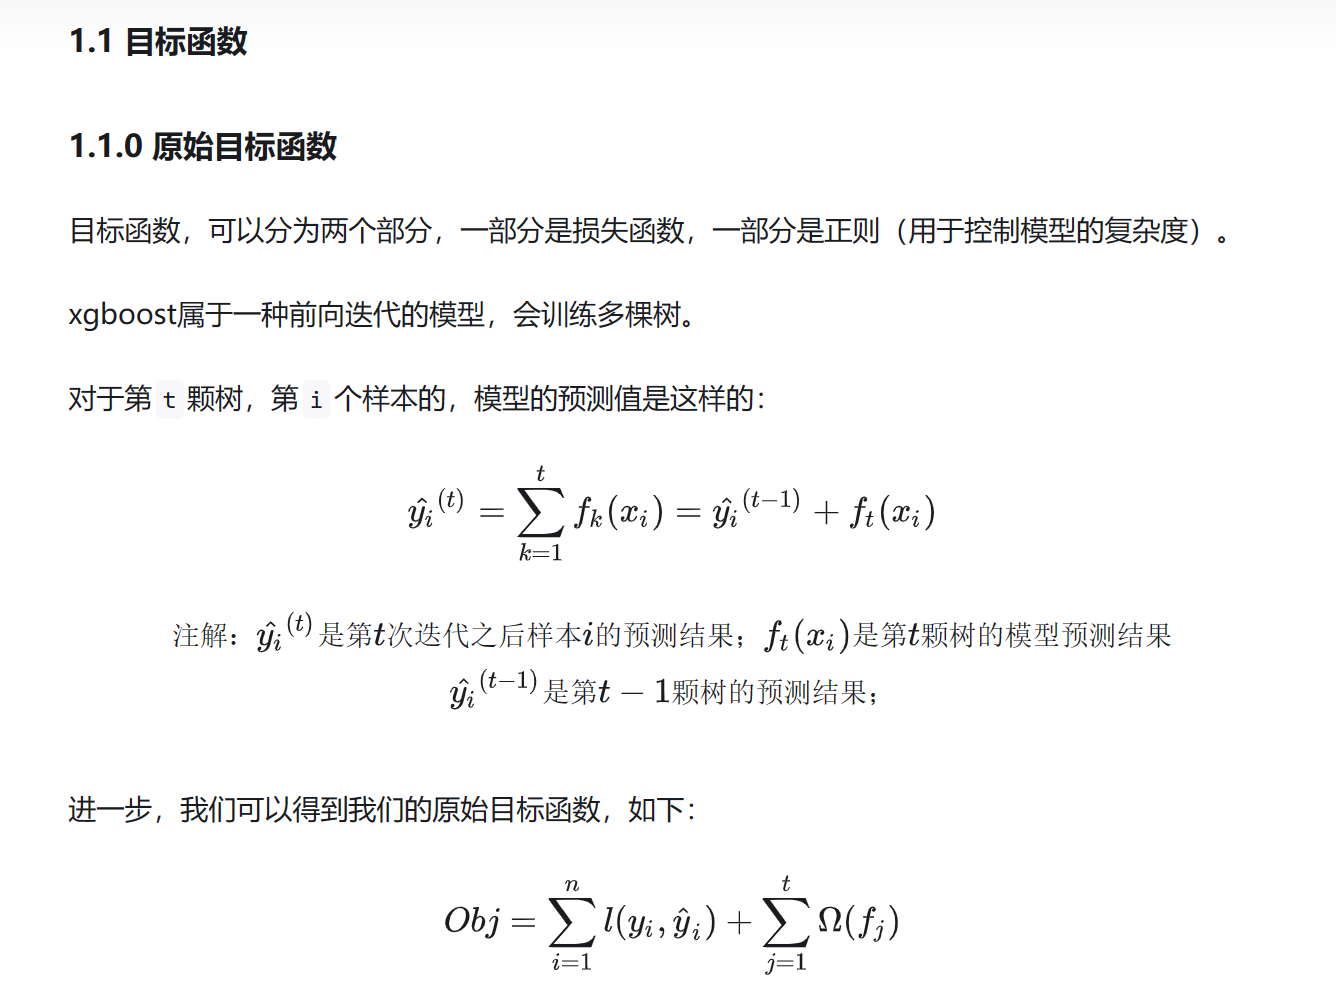
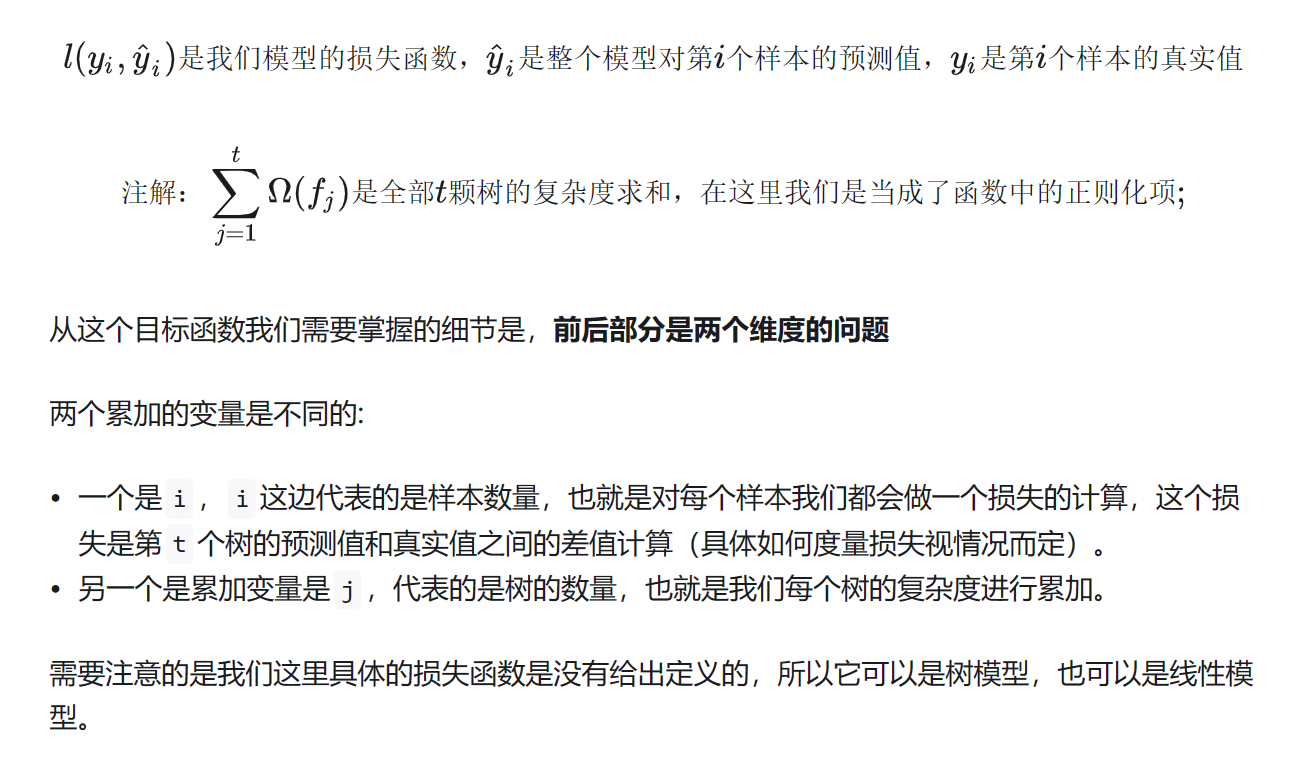
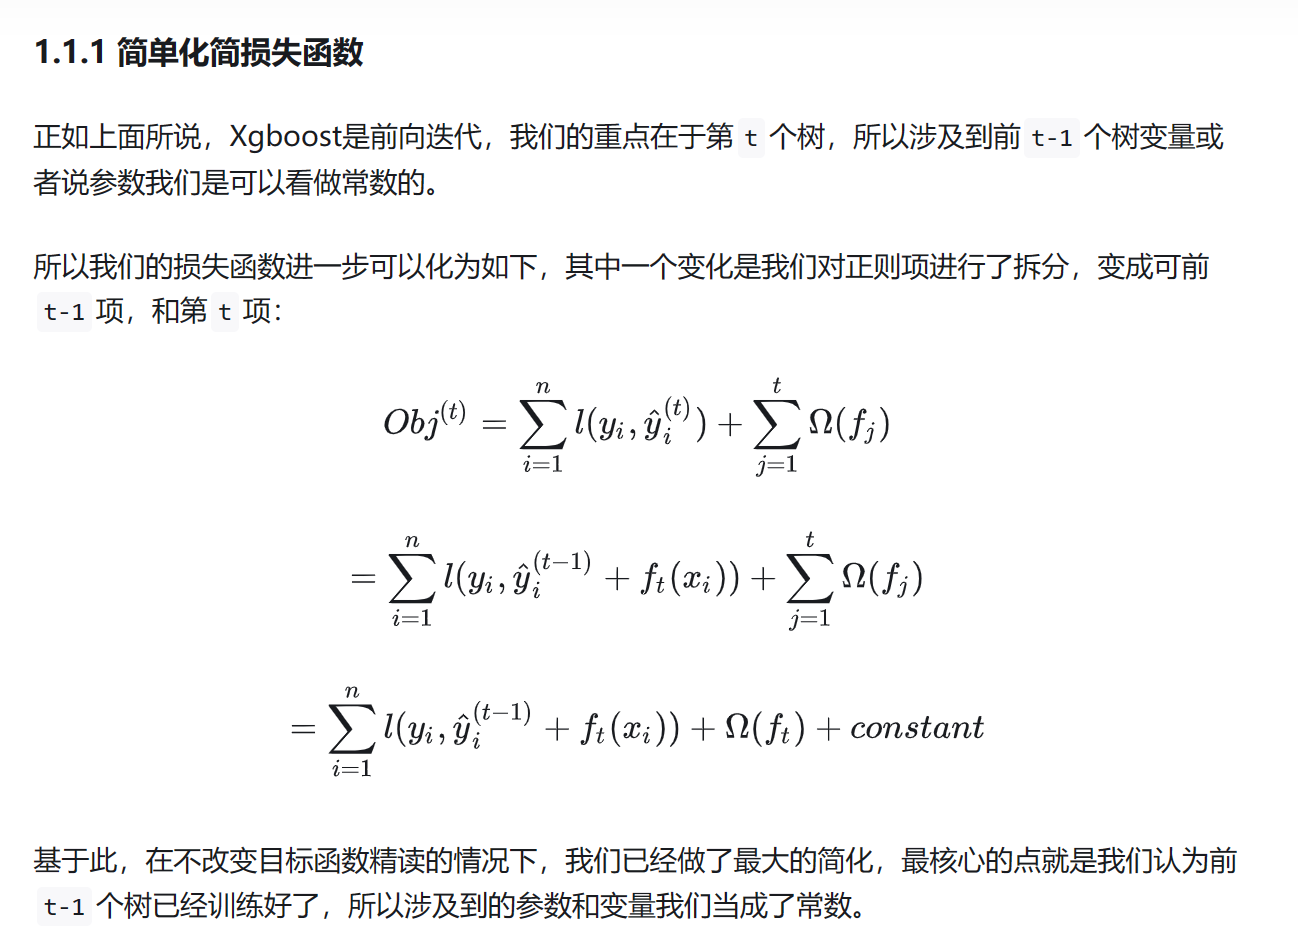
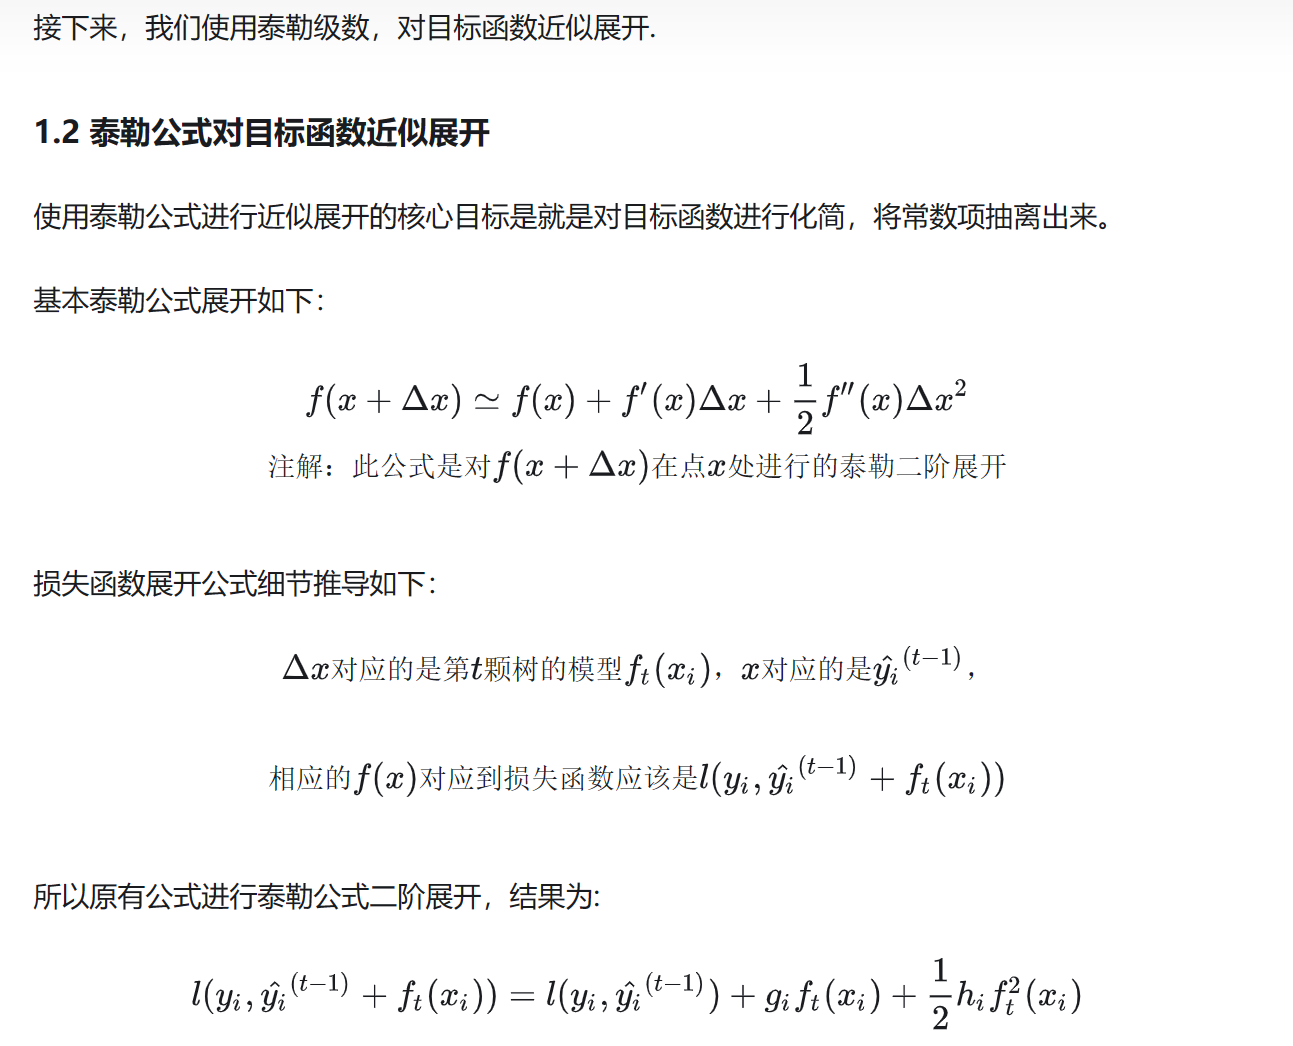
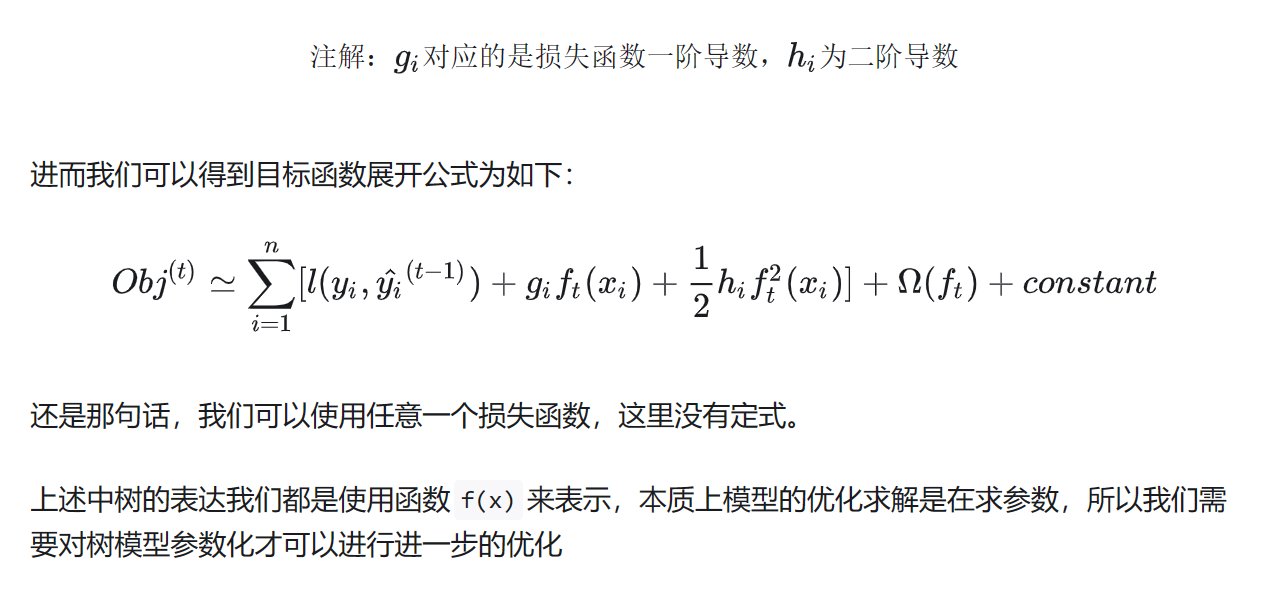
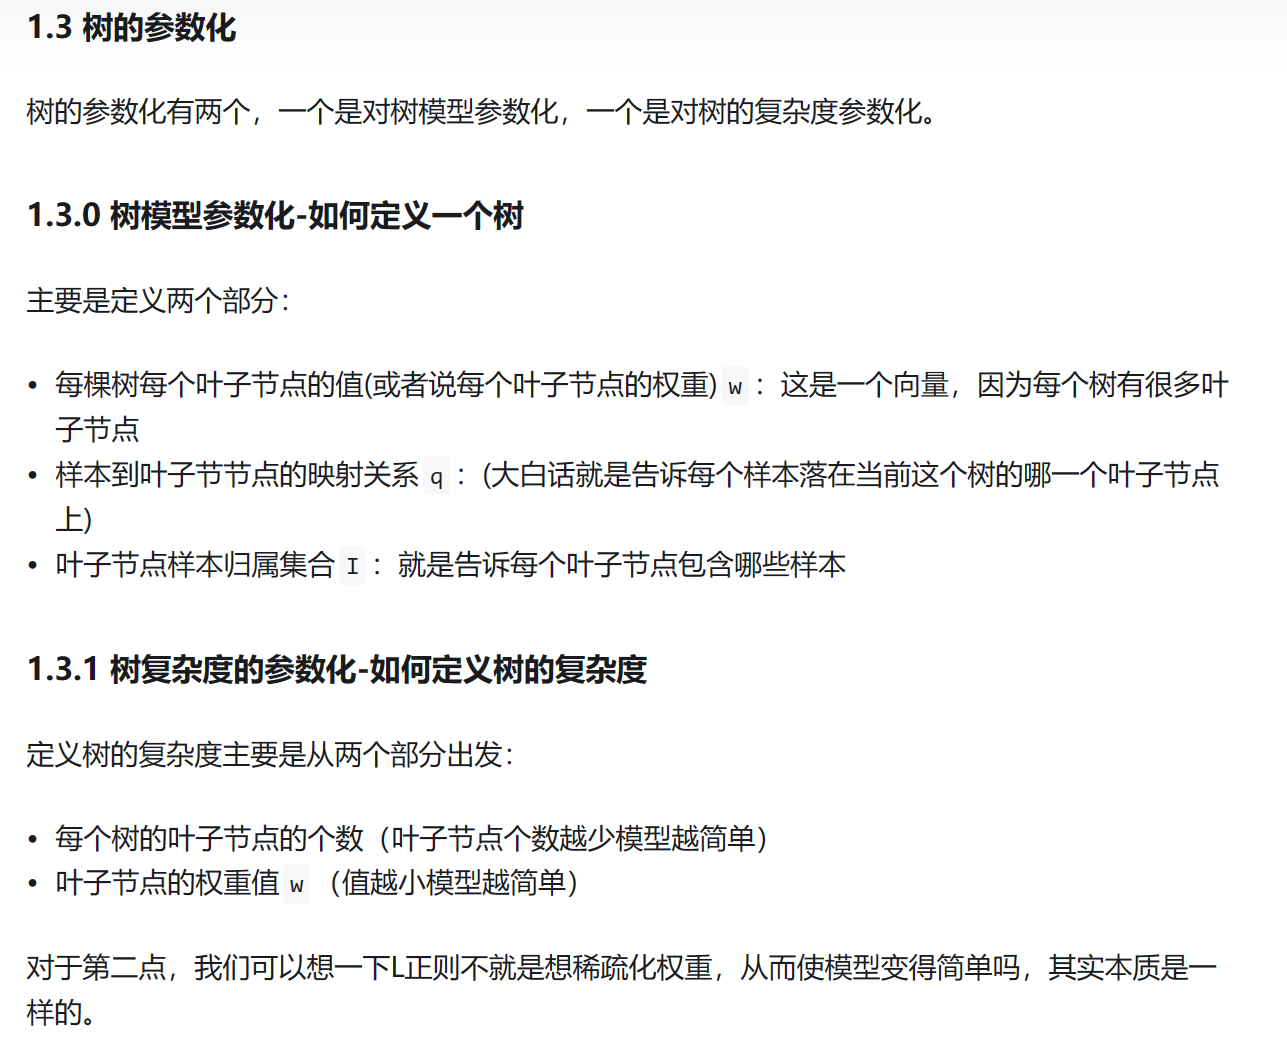
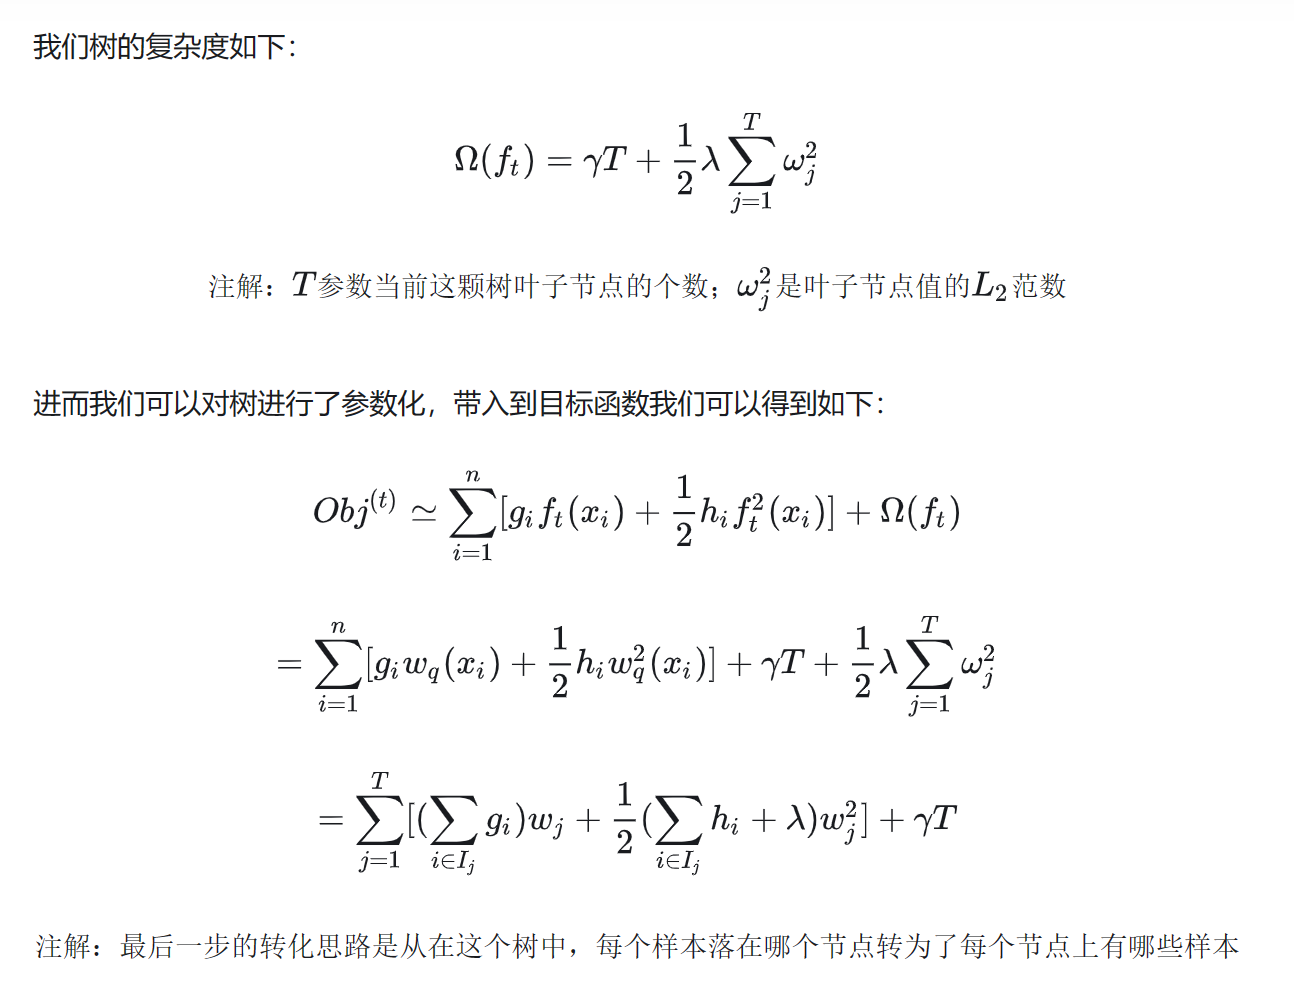
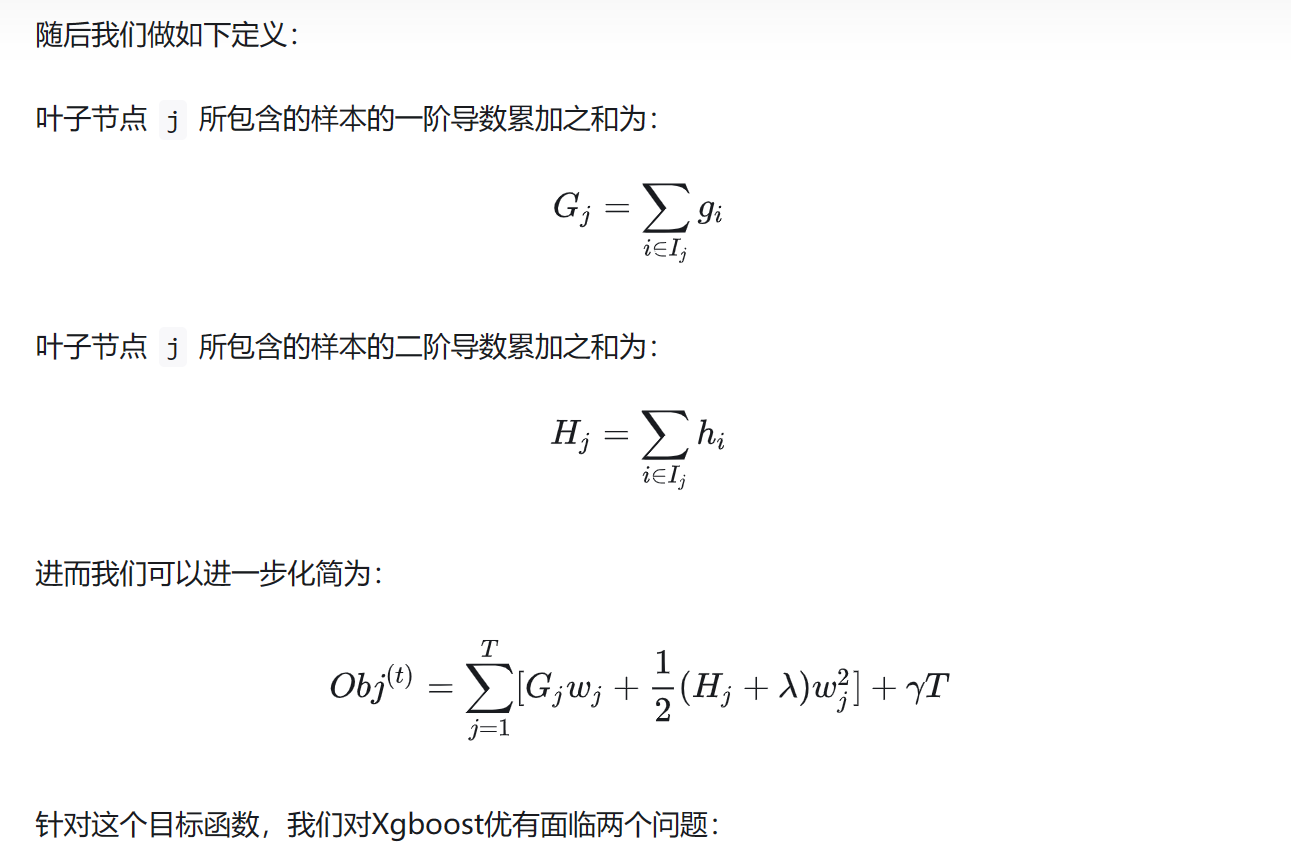
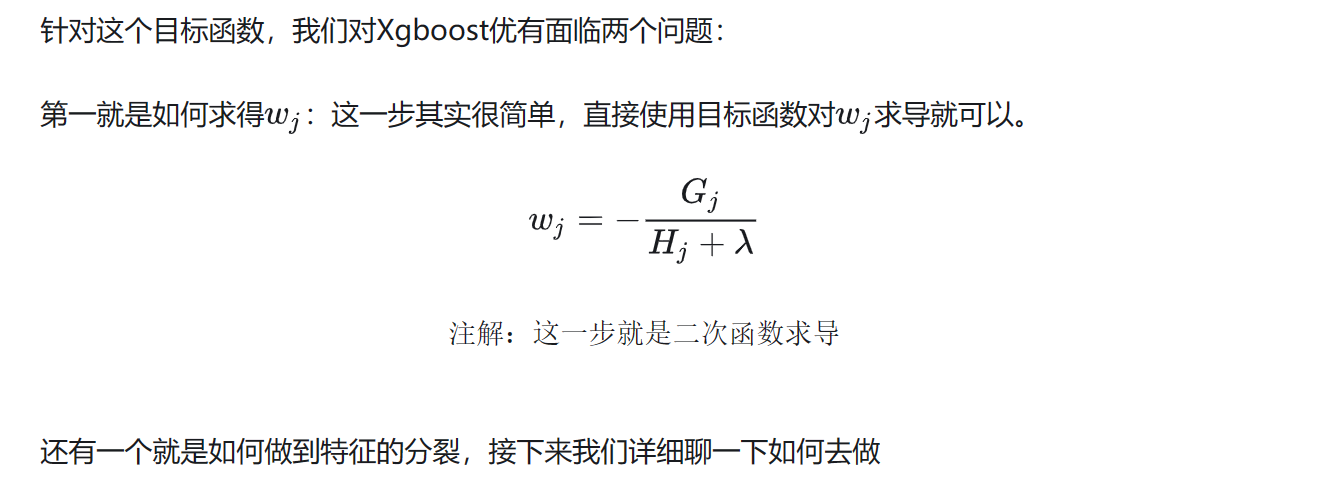
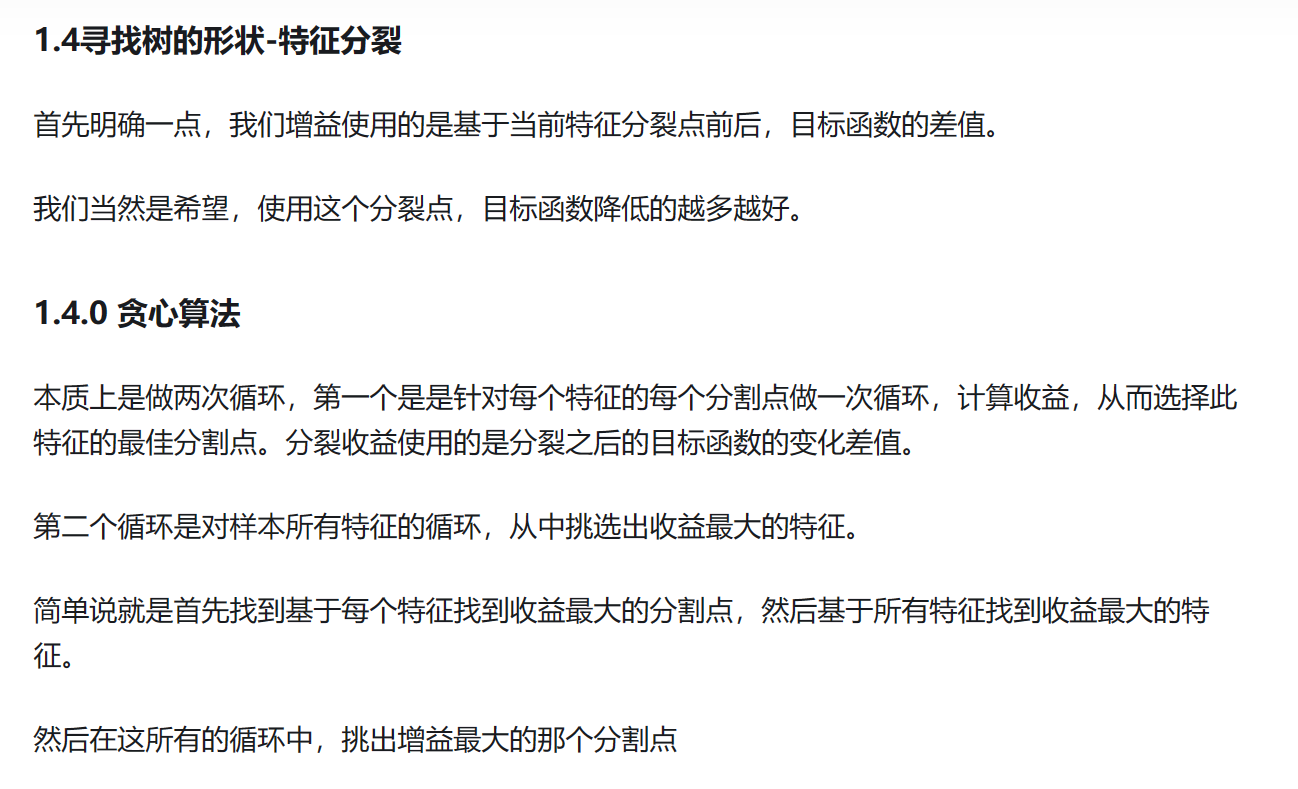
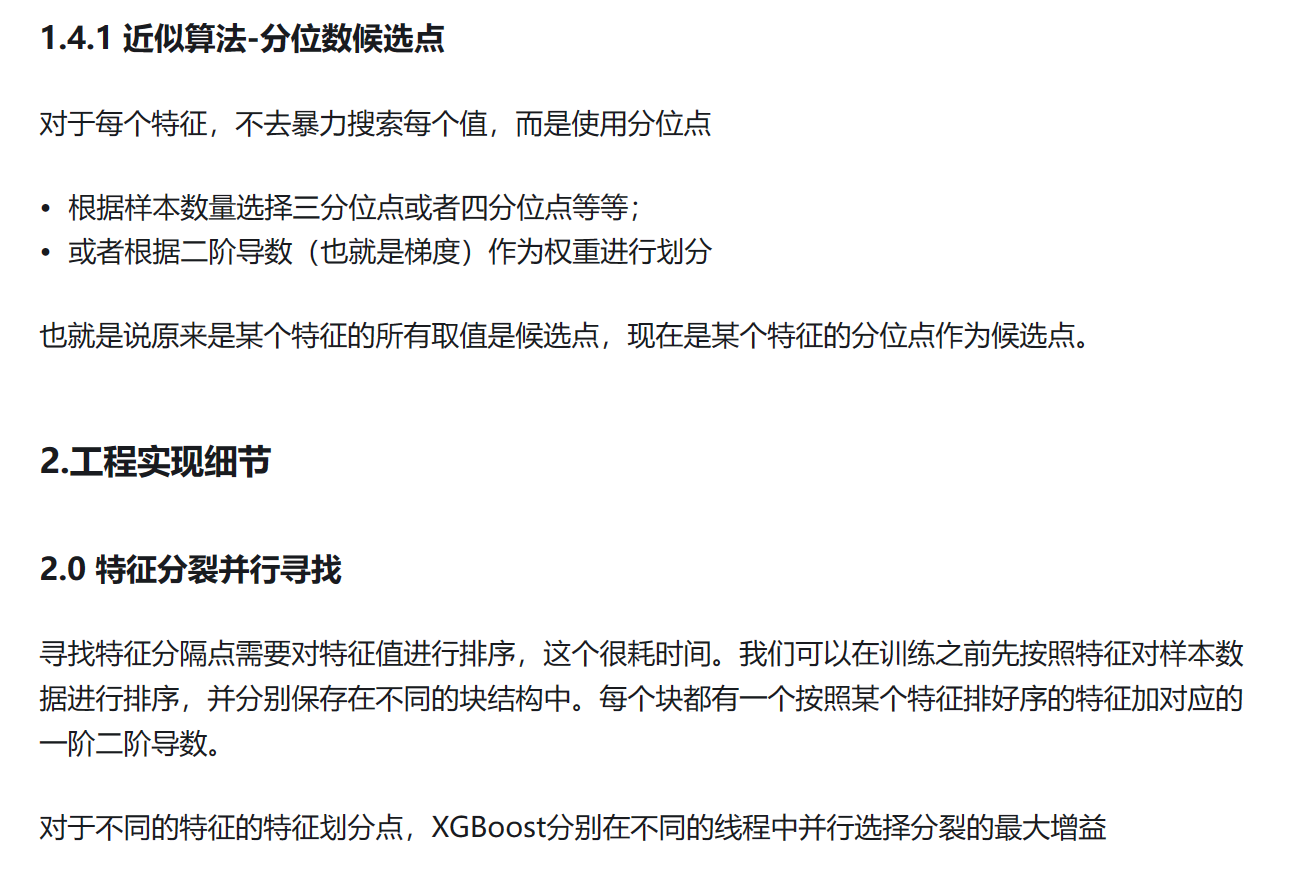
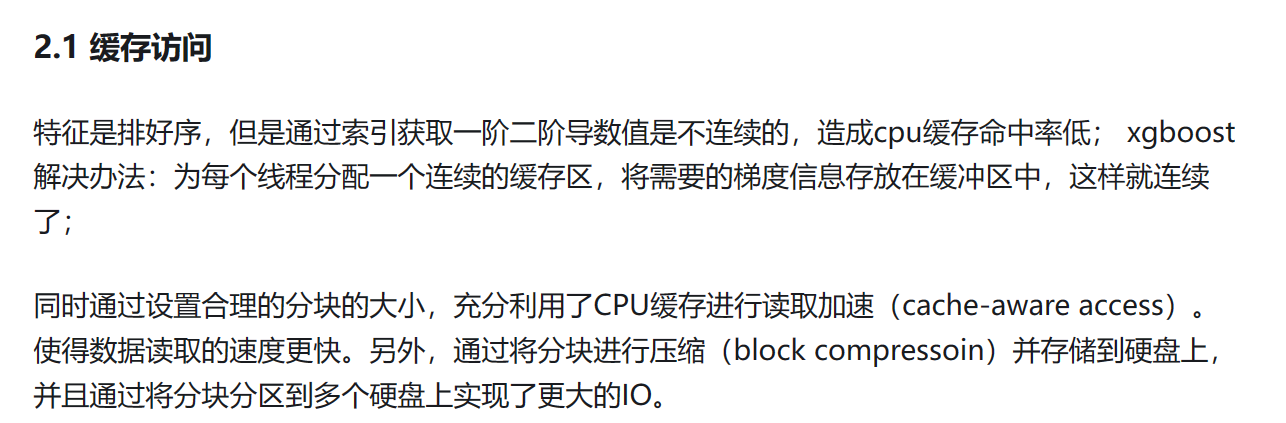
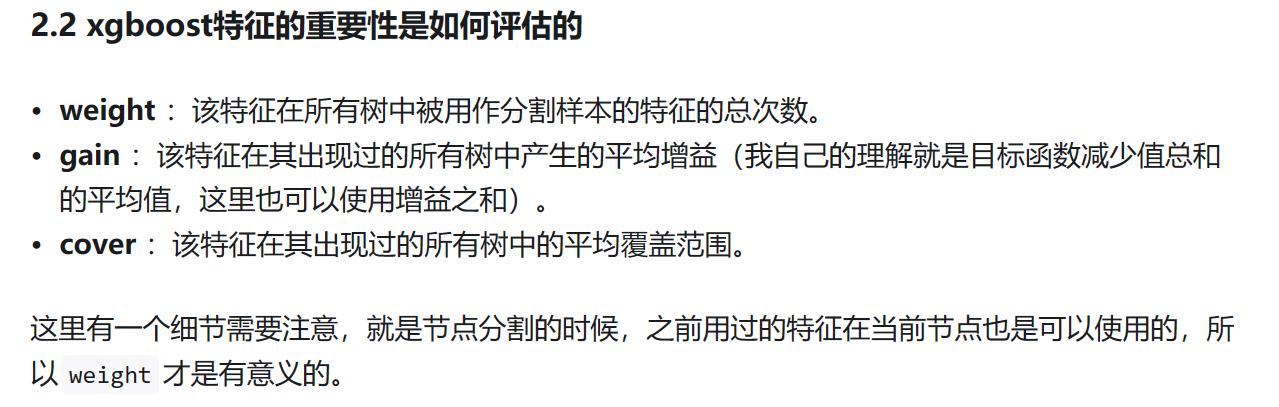
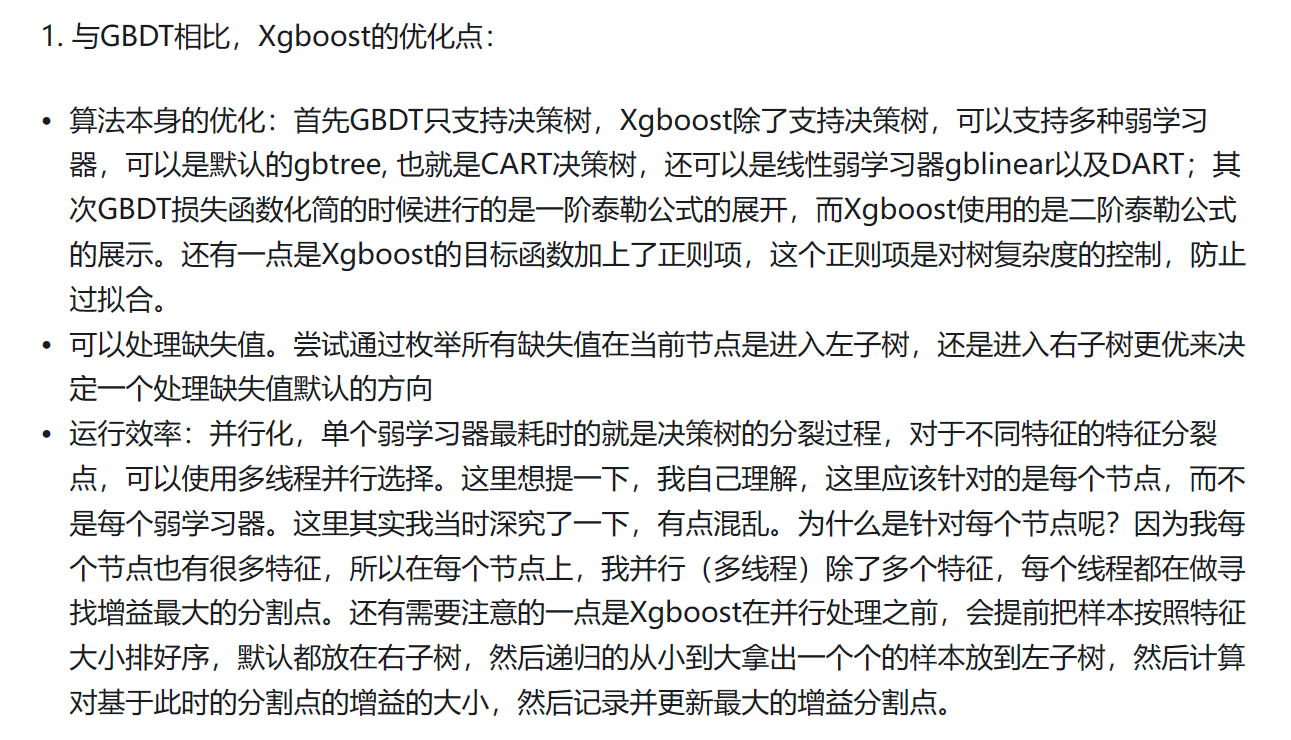

XGBoost的并行不是树粒度的而是特征粒度的，随机森林就是树粒度的并行。

寻找分裂点的时候，算法中先是遍历所有特征再遍历每个特征下的所有值。

遍历特征下所有值时要求值是排序好的，这样就可以使用差加速。
如果不排序，那么计算分类时候的损失函数减少量就没法达到O(1)的复杂度，因为二叉树的分裂是> x,分到a子树这样的形式。

在建树的过程中，最耗时是找最优的切分点，而这个过程中，最耗时的部分是将数据排序。为了减少排序的时间，提出Block结构存储数据。

- Block中的数据以稀疏格式CSC进行存储
- Block中的特征进行排序（不对缺失值排序，排序只有一次）
- Block 中特征还需存储指向样本的索引，这样才能根据特征的值来取梯度。
- 一个Block中存储一个或多个特征的值

这个block是原样本的一种映射，在这个block里，"样本"是按照列存储的，其实他存储的是列，而不是样本。因为样本是按照行来组织的，block中存储的是原样本的各个排序后的列。

所以就要有列中的每个元素与原样本之间的映射关系，因为在分裂节点的选择时，不仅要遍历某个特征（即列）中的所有元素，还要用到原样本的梯度（一阶导和二阶导）， 所以就要通过列中的元素找到原样本。

按照block存储的好处就是，不同列之间可以并行查找，并且因为预排序了所以使得分裂节点查找时更快。坏处是空间大了一倍。

在分块并行中，block存储了排序的列，并建立和原来样本的一一映射，这样可以通过索来找到原始样本获得梯度，但是原始样本是存放是按照列值的原始顺序的（相邻内存的样本他们对应的列值可能不是连续的，而我们现在根据排序后的列值来找原样本，那么肯定会出现在内存上的跳跃式查找，就非连续内存访问，可能导致CPU cache命中率降低。

CPU cache命中率低对于加权分位数选择分裂点的方法没太大影响，因为其选择分裂点的时候本来就是跳跃着选的，但是对于精确贪心算法的效率影响就非常大了，因为其要遍历所有样本。

通过降低读写的依赖性来解决cache miss的问题  
1.对于精确贪心算法，对每个线程分配一个连续的缓存空间，预取接下来要读取的数据，这样就降低了直接从内存读取并且cache miss消耗的时间。  
2.对于近似分割算法，选取适当的block大小即可（2^16 * each_sample_size)。

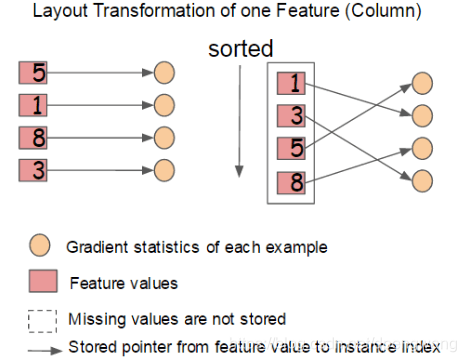

# 数据准备

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [3]:
#读取数据
data = pd.read_csv("../data/iris.csv")
print(data.head())

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [6]:
#准备数据
data = data.dropna()
y = data['Species'].apply(lambda x: 0 if x == 'setosa' else 1 if x == 'versicolor' else 2)
x = data.drop(['Species'],axis=1).astype('float64')

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state= 42)

# 模型训练

In [8]:
# 分类模型、参数
model = XGBClassifier()
param_grid = {'n_estimators': [10, 100, 200], 'max_depth': [5, 10, 20], 'learning_rate': [0.1, 0.001, 0.112]}

# GridSearchCV优化参数、训练模型
gsearch = GridSearchCV(model, param_grid)
model = gsearch.fit(x_train, y_train)

# 打印最优结果
print('XGB params:', model.best_estimator_)

XGB params: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


In [14]:
xgb = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.1, random_state=0)
xgb.fit(x_train, y_train)
xgb.feature_importances_ # 特征重要性

array([0.00943622, 0.05754278, 0.6204582 , 0.31256282], dtype=float32)

Text(0, 0.5, 'Feature')

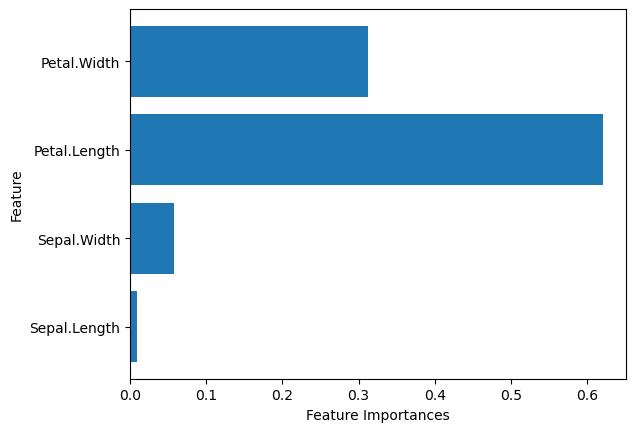

In [17]:
can = {n:v for n,v in zip(data.columns,xgb.feature_importances_)}
plt.barh(list(can.keys()),list(can.values()),align = 'center')
plt.xlabel("Feature Importances")
plt.ylabel("Feature")

# 模型保存

In [9]:
# 法一
import joblib

# 保存模型
joblib.dump(model, '../outputs/best_models/xgb.pkl')

# 加载模型
model = joblib.load('../outputs/best_models/xgb.pkl')

In [10]:
# 法二
import pickle

with open('../outputs/best_models/xgb.pkl', 'wb') as f:
    pickle.dump(model, f)

#读取Model
with open('../outputs/best_models/xgb.pkl', 'rb') as f:
    model = pickle.load(f)

# 模型预测

In [11]:
prediction = model.predict(x_test)

In [12]:
# 计算准确率
acc = accuracy_score(y_test, prediction)
print("acc为：", acc)

acc为： 1.0


In [13]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

